In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.distributions.log_normal import LogNormal

# Internal packages
from data_loader import KidneyStoneDataset, ToTensor
from model import binary_ks_net, binary_neg_loglik, cont_rec_ks_net, cont_rec_neg_loglik, cont_size_ks_net, cont_size_neg_loglik
from train import train

In [2]:
# For graphing purposes below
import matplotlib.pyplot as plt 
import seaborn as sns

from torch.distributions.bernoulli import Bernoulli 
from torch.distributions.normal import Normal

import numpy as np

In [3]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS     = 150
LEARN_R    = 5e-4 #1e-3 #1e-2 # RMS
N_HU       = 32
NLA = torch.tanh #torch.sigmoid #F.relu 
#NLA = nn.LeakyReLU(1) # For a linear neural network

mean_idx = [2]
sd_idx = [0, 2] # Standarize the two continuous variables

# Initialize the dataset
data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
#data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
train_loader = DataLoader(data, batch_size=BATCH_SIZE)

# Initialize the model
model = cont_size_ks_net(N_HU, NLA)

# Optimizers
#optimizer = optim.SGD(model.parameters(), lr=LEARN_R)
optimizer = optim.RMSprop(model.parameters(), lr=LEARN_R)

In [4]:
cum_loss = train(model, optimizer, cont_size_neg_loglik, train_loader, EPOCHS)

In [5]:
# First, we get the parameters of the size variable:
n_samples = 20000
arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
L_dist = LogNormal(mu_L, sigma_L)
L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

In [6]:
# "Create" the queries using the samples from the distribution
t_1 = torch.cat((L_samples, torch.ones(n_samples, 2)), 1)
t_0 = torch.cat((L_samples, torch.zeros(n_samples, 1) ,torch.ones(n_samples, 1)), 1)

In [7]:
# Means of standarized recovery:
_, _, _, mu_t1, _ = model(t_1) # With treatment A
_, _, _, mu_t0, _ = model(t_0) # With treatment B

# Come back to the normal scale
mu_t1 = (mu_t1*data.sd[2])+data.mean[2]
mu_t0 = (mu_t0*data.sd[2])+data.mean[2]

In [8]:
mu_t1_less_10 = mu_t1[L_samples*data.sd[0] < 10]
mu_t1_gret_10 = mu_t1[L_samples*data.sd[0] >= 10]
mu_t0_less_10 = mu_t0[L_samples*data.sd[0] < 10]
mu_t0_gret_10 = mu_t0[L_samples*data.sd[0] >= 10]

In [9]:
for n in [1, 5, 25, 50, 100, 500, 1000, 5000]:
    print("%d: %f" % (n, torch.mean(mu_t1_gret_10[:n]-mu_t0_gret_10[:n])))

1: 9.669120
5: 9.517179
25: 9.820997
50: 9.823017
100: 9.728259
500: 9.740017
1000: 9.751904
5000: 9.752155


In [10]:
for n in [1, 5, 25, 50, 100, 500, 1000, 5000]:
    print("%d: %f" % (n, torch.mean(mu_t1_less_10[:n]-mu_t0_less_10[:n])))

1: 7.953938
5: 8.468092
25: 8.778862
50: 8.840540
100: 8.894409
500: 8.884513
1000: 8.911840
5000: 8.920799


In [9]:
# Ancestral sampling
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 2000
arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
L_dist = LogNormal(mu_L, sigma_L)
L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

########################### T SAMPLES ###########################
_, _, p_T, _, _ = model(torch.cat((L_samples, torch.ones(n_samples, 2)), 1))

T_dist = Bernoulli(p_T)
T_samples = T_dist.sample().view(n_samples,1)

########################### R SAMPLES ###########################
_, _, _, mu_R, log_sigma_R = model(torch.cat((L_samples, T_samples, torch.ones(n_samples, 1)), 1))

sigma_R = torch.exp(log_sigma_R)

R_dist = Normal(mu_R, sigma_R)
R_samples = R_dist.sample().view(n_samples,1)

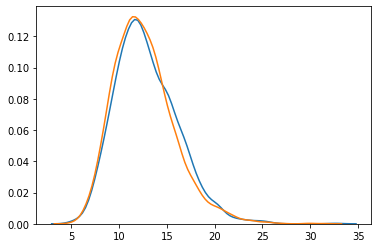

In [10]:
ax = sns.kdeplot((L_samples*data.sd[0]).numpy()[:,0])
ax = sns.kdeplot(data.ks_dataset[:,0])

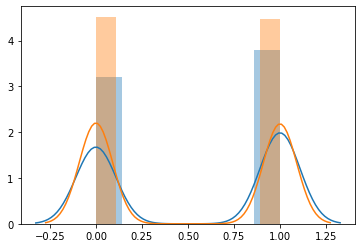

In [11]:
ax = sns.distplot((T_samples).detach().numpy()[:,0])
ax = sns.distplot(data.ks_dataset[:,1])

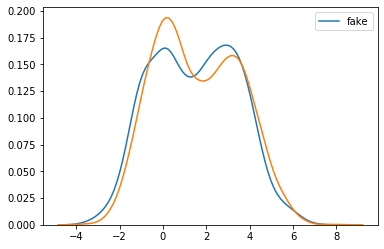

In [12]:
ax = sns.kdeplot((R_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="fake")
ax = sns.kdeplot(data.ks_dataset[:,2])

In [13]:
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 200
arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
L_dist = LogNormal(mu_L, sigma_L)
L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

########################### T SAMPLES ###########################
T1_samples = torch.ones(n_samples, 1)
T0_samples = torch.zeros(n_samples, 1)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((L_samples, T1_samples, torch.ones(n_samples, 1)), 1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample().view(n_samples,1)

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((L_samples, T0_samples, torch.ones(n_samples, 1)), 1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample().view(n_samples,1)

In [14]:
print(np.mean(data.ks_dataset[:,2]))
print(np.mean((R1_samples*data.sd[2]+data.mean[2]).numpy()[:,0]))

1.5931501622948436
3.0135703


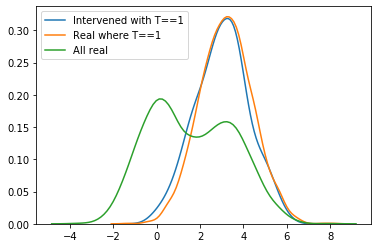

In [15]:
ax = sns.kdeplot((R1_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Intervened with T==1")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==1,2], label="Real where T==1")
ax = sns.kdeplot(data.ks_dataset[:,2], label="All real")

In [16]:
print(np.mean(data.ks_dataset[:,2]))
print(np.mean((R0_samples*data.sd[2]+data.mean[2]).numpy()[:,0]))

1.5931501622948436
-0.32742178


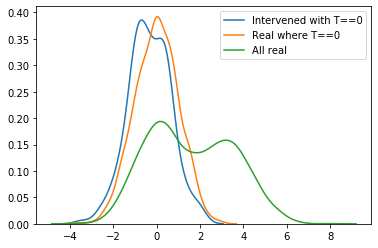

In [17]:
ax = sns.kdeplot((R0_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Intervened with T==0")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==0,2], label="Real where T==0")
ax = sns.kdeplot(data.ks_dataset[:,2], label="All real")

In [18]:
# Single sample
s_sample = data.__getitem__(0).unsqueeze(0)

In [19]:
# Ancestral sampling
from torch.distributions.bernoulli import Bernoulli 
from torch.distributions.normal import Normal 

########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 500
#arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
#mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
#sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
#L_dist = LogNormal(mu_L, sigma_L)
#L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

########################### T SAMPLES ###########################
_, _, p_T, _, _ = model(s_sample)

T_dist = Bernoulli(p_T)
T_samples = T_dist.sample(sample_shape=torch.Size([n_samples,1]))

########################### R SAMPLES ###########################
_, _, _, mu_R, log_sigma_R = model(torch.cat((s_sample[0][0].expand(n_samples).unsqueeze(0), T_samples.squeeze().unsqueeze(0), torch.ones(n_samples).unsqueeze(0)), 0).T)

sigma_R = torch.exp(log_sigma_R)

R_dist = Normal(mu_R, sigma_R)
R_samples = R_dist.sample().view(n_samples,1)

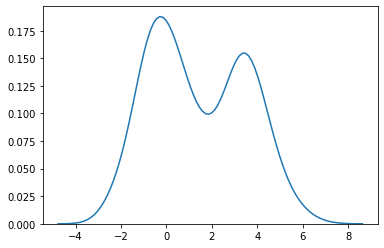

In [20]:
ax = sns.kdeplot((R_samples*data.sd[2]+data.mean[2]).numpy()[:,0])

In [21]:
s_sample*data.sd[2]+data.mean[2]

tensor([[7.9029, 3.5447, 3.5441]])

In [22]:
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 500

########################### T SAMPLES ###########################
_, _, p_T, _, _ = model(s_sample)

T1 = torch.ones(1, 2)
T0 = torch.zeros(1, 2)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((s_sample[0][0].view(1,1), T1), -1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample(sample_shape=torch.Size([n_samples,1]))

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((s_sample[0][0].view(1,1), T0), -1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample(sample_shape=torch.Size([n_samples,1]))

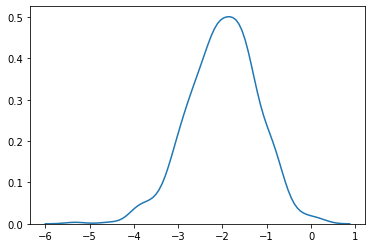

In [23]:
ax = sns.kdeplot((R0_samples-R1_samples).squeeze().numpy())

In [24]:
4/(s_sample.numpy()[0][0])

1.2371791704686619

In [25]:
np.mean((p_T*R1_samples-(1-p_T)*R0_samples).squeeze().detach().numpy())

0.9953513

In [26]:
# How well does it learn the data?
########################### R SAMPLES ###########################
nn_input = torch.tensor(data.ks_dataset).float()
nn_input[:, data.idx_mean] -= data.mean[data.idx_mean] 
nn_input[:, data.idx_sd]   /= data.sd[data.idx_sd]
_, _, _, mu_R, log_sigma_R = model(nn_input)

sigma_R = torch.exp(log_sigma_R)

R_dist = Normal(mu_R, sigma_R)
R_samples = R_dist.sample()

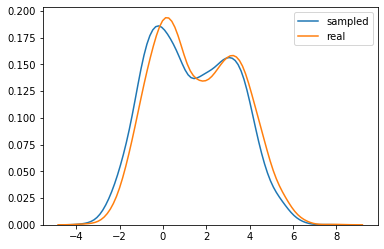

In [27]:
ax = sns.kdeplot((R_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="sampled")
ax = sns.kdeplot(data.ks_dataset[:,2], label="real")

In [224]:
data = data.ks_dataset

In [226]:
np.min(data[data[:,1]==1, 2])

4.577675478474989

In [228]:
np.min(data[data[:,1]==0, 2])

0.050319762174558136

In [227]:
np.max(data[data[:,1]==0, 2])

21.6588376570144

In [229]:
np.max(data[data[:,1]==1, 2])

30.16774227154499

In [28]:
# Constrained causal effects
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
n_samples = 1000
arbitrary_query = torch.tensor([1., 1., 1.]) # It is only important that the first element is 1

# Extract the parameters
mu_L, log_sigma_L, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_L = torch.exp(log_sigma_L)

# Sample from the distribution
L_dist = LogNormal(mu_L, sigma_L)
L_samples = L_dist.sample((n_samples,)).view(n_samples,1)

L_samples = L_samples[(L_samples*data.sd[0] < 21.65) & (L_samples*data.sd[0] > 4.57)]
print(L_samples.shape)

########################### T SAMPLES ###########################
T1_samples = torch.ones(L_samples.shape[0], 1)
T0_samples = torch.zeros(L_samples.shape[0], 1)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((L_samples.view(-1,1), T1_samples, torch.ones(L_samples.shape[0], 1)), 1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample().view(L_samples.shape[0],1)

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((L_samples.view(-1,1), T0_samples, torch.ones(L_samples.shape[0], 1)), 1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample().view(L_samples.shape[0],1)

torch.Size([986])


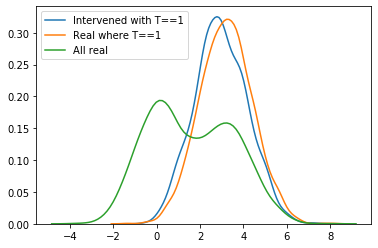

In [29]:
ax = sns.kdeplot((R1_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Intervened with T==1")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==1,2], label="Real where T==1")
ax = sns.kdeplot(data.ks_dataset[:,2], label="All real")

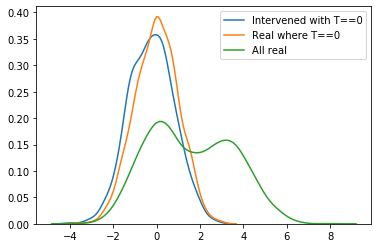

In [30]:
ax = sns.kdeplot((R0_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Intervened with T==0")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==0,2], label="Real where T==0")
ax = sns.kdeplot(data.ks_dataset[:,2], label="All real")

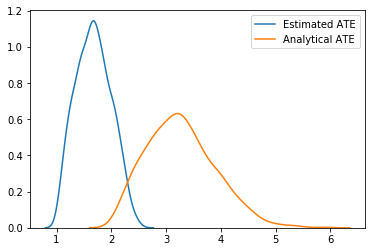

In [33]:
ax = sns.kdeplot((mu_R1-mu_R0).detach().numpy()[:,0], label="Estimated ATE")
ax = sns.kdeplot((50/(L_samples*data.sd[0]+3)).numpy(), label="Analytical ATE")

In [34]:
# Single sample
s_sample = data.__getitem__(0).unsqueeze(0)

In [35]:
data_torch = torch.tensor(data.ks_dataset).float()

In [36]:
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
L_samples_0 = data_torch[data_torch[:,1]==0, 0]/data.sd[0]
L_samples_1 = data_torch[data_torch[:,1]==1, 0]/data.sd[0]

########################### T SAMPLES ###########################
T1_samples = torch.ones(L_samples_1.shape[0], 1)
T0_samples = torch.zeros(L_samples_0.shape[0], 1)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((L_samples_1.view(-1,1), T1_samples, torch.ones(L_samples_1.shape[0], 1)), 1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample().view(L_samples_1.shape[0],1)

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((L_samples_0.view(-1,1), T0_samples, torch.ones(L_samples_0.shape[0], 1)), 1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample().view(L_samples_0.shape[0],1)

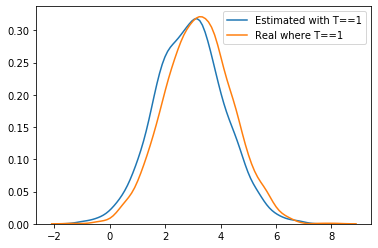

In [37]:
ax = sns.kdeplot((R1_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Estimated with T==1")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==1,2], label="Real where T==1")

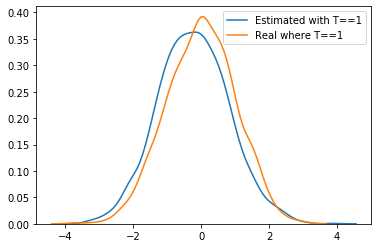

In [38]:
ax = sns.kdeplot((R0_samples*data.sd[2]+data.mean[2]).numpy()[:,0], label="Estimated with T==1")
ax = sns.kdeplot(data.ks_dataset[data.ks_dataset[:,1]==0,2], label="Real where T==1")

In [57]:
# Ancestral sampling
########################### KS SAMPLES ###########################
# First, we get the parameters of the size variable:
L_samples = torch.arange(0, 25, 0.1)/data.sd[0]
n = L_samples.shape[0]

########################### T SAMPLES ###########################
T1_samples = torch.ones(n, 1)
T0_samples = torch.zeros(n, 1)

########################### R SAMPLES ###########################
# T1
_, _, _, mu_R1, log_sigma_R1 = model(torch.cat((L_samples.view(-1,1), T1_samples, torch.ones(n, 1)), 1))

sigma_R1 = torch.exp(log_sigma_R1)

R1_dist = Normal(mu_R1, sigma_R1)
R1_samples = R1_dist.sample().view(n,1)

#T0
_, _, _, mu_R0, log_sigma_R0 = model(torch.cat((L_samples.view(-1,1), T0_samples, torch.ones(n, 1)), 1))

sigma_R0 = torch.exp(log_sigma_R0)

R0_dist = Normal(mu_R0, sigma_R0)
R0_samples = R0_dist.sample().view(n,1)

In [44]:
TE = ((mu_R1*data.sd[2]+data.mean[2])-(mu_R0*data.sd[2]+data.mean[2])).detach().numpy()

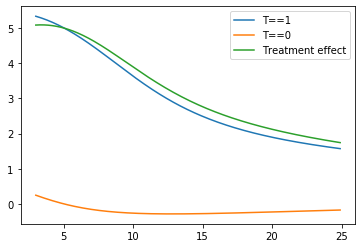

In [45]:
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="T==1")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="T==0")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=TE[:,0], label="Treatment effect")

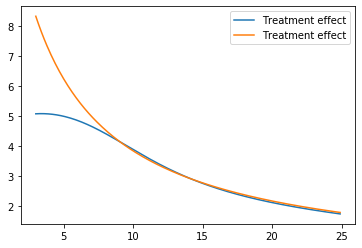

In [47]:
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=TE[:,0], label="Treatment effect")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=(50/(3+L_samples*data.sd[0])).numpy(), label="Treatment effect")

In [18]:
mu    = 2.5
sigma = 0.25

cutoff = 10         # Cutoff for declaring big or small stones, this is the mean of the gamma
p_a_l = 40/100      # Original p_a_l = 263/343     # Probability of getting treatment a given small stones
p_b_l = 263/343     # Original p_b_l = 80/343      # Probability of getting treatment b given small stones

# Simulation
size = np.random.lognormal(mu, sigma, size=(n,1))        # Simulation of kidney stone size
l = size > cutoff
a = np.random.binomial(1, l*p_a_l + (1-l)*(1-p_a_l)) #a = np.random.binomial(1, l*p_a_l + (1-l)*(1-p_a_l)) # Simulation of treatment
r = np.random.normal(4*a*np.exp(2*l) + size, 1, size=(n,1)) # Simulation of recovery # Original had sigma 2 and mean 4*a*np.exp(l) + size

# Simulation
size = np.arange(0, 25, step =0.1)
l = size > cutoff
a = np.random.binomial(1, l*p_a_l + (1-l)*(1-p_a_l)) # Simulation of treatment
a0 = np.zeros(250)
a1 = np.ones(250)
r0 = np.random.normal(4*a0*np.exp(2*l) + size, 1, size=(250, 1)) # Simulation of recovery
r1 = np.random.normal(4*a1*np.exp(2*l) + size, 1, size=(250, 1)) # Simulation of recovery

# Getting them together:
data0 = np.hstack((size[:, np.newaxis], a0[:, np.newaxis], r0))
data1 = np.hstack((size[:, np.newaxis], a1[:, np.newaxis], r1))

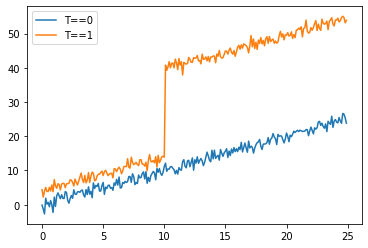

In [19]:
ax = sns.lineplot(x=data0[:,0], y=data0[:,2], label="T==0")
ax = sns.lineplot(x=data1[:,0], y=data1[:,2], label="T==1")

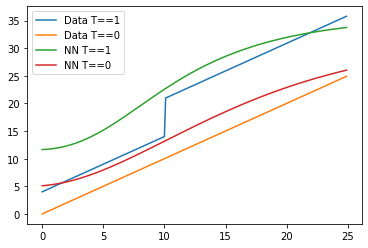

In [20]:
ax = sns.lineplot(x=data1[:,0], y=4*data1[:,1]*np.exp(l) + data1[:,0], label="Data T==1")
ax = sns.lineplot(x=data0[:,0], y=4*data0[:,1]*np.exp(l) + data0[:,0], label="Data T==0")

ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==1")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==0")
#ax = sns.lineplot(x=data1[:,0], y=data1[:,2], label="T==1")
#ax = sns.lineplot(x=data1[:,0], y=data1[:,2]-data0[:,2], label="Treatment effect")

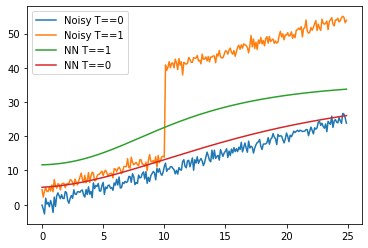

In [21]:
ax = sns.lineplot(x=data0[:,0], y=data0[:,2], label="Noisy T==0")
ax = sns.lineplot(x=data1[:,0], y=data1[:,2], label="Noisy T==1")

ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==1")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==0")

In [22]:
data_te = (4*data1[:,1]*np.exp(2*l) + data1[:,0]) - (4*data0[:,1]*np.exp(2*l) + data0[:,0])
noisy_te = data1[:,2]-data0[:,2]

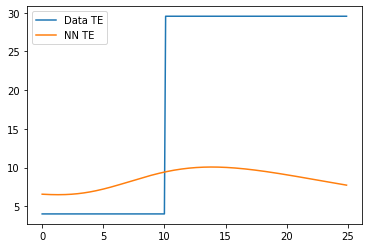

In [23]:
ax = sns.lineplot(x=data1[:,0], y=data_te, label="Data TE")
ax = sns.lineplot(x=data1[:,0], y=TE[:,0], label="NN TE")

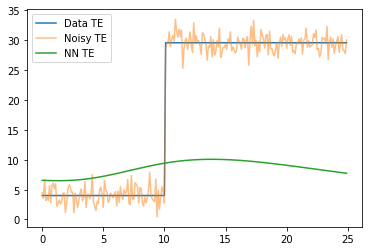

In [24]:
ax = sns.lineplot(x=data1[:,0], y=data_te, label="Data TE")
ax = sns.lineplot(x=data1[:,0], y=noisy_te, label="Noisy TE", alpha=0.5)
ax = sns.lineplot(x=data1[:,0], y=TE[:,0], label="NN TE")

In [48]:
mu    = 2.5
sigma = 0.25

# Simulation
size = np.arange(0, 25, step =0.1)        # Simulation of kidney stone size
norm_size = size-np.mean(size)
p = 1/(1+np.exp(-norm_size/10)) # Original p = 1/(1+np.exp(-norm_size))
a = np.random.binomial(1, p) # Simulation of treatment
r = np.random.normal((50*a)/(size+3), 1, size=len(size)) # Simulation of recovery

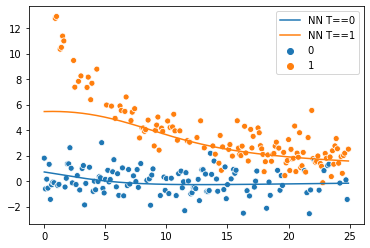

In [58]:
ax = sns.scatterplot(x=size, y=r, hue=a)
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R0*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==0")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=((mu_R1*data.sd[2])+data.mean[2]).detach().numpy()[:,0], label="NN T==1")

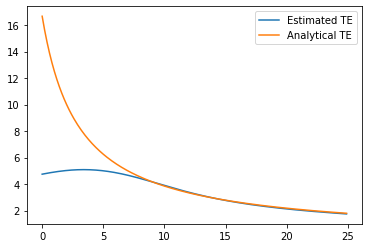

In [64]:
TE = (((mu_R1*data.sd[2])+data.mean[2])- ((mu_R0*data.sd[2])+data.mean[2])).detach().numpy()
analytical_TE = (50/(3+(L_samples*data.sd[0]))).numpy()
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=TE[:,0], label="Estimated TE")
ax = sns.lineplot(x=(L_samples*data.sd[0]).numpy(), y=analytical_TE, label="Analytical TE")
